In [1]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
from lenstronomy.Data.image_noise import ImageNoise


In [2]:
np.random.seed(41)

## Load psf file

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


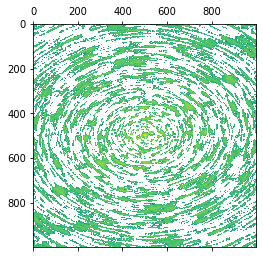

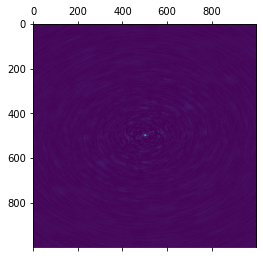

In [3]:
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, '/Users/ZN/desktop/lenstronomy/dms_0418_natwt.psf.fits')
psf = pyfits.getdata(psf_filename)
psf=np.nan_to_num(psf[0][0])


plt.matshow(np.log10(psf))
plt.matshow(psf)
plt.show()


## Construct covariance matrix M from the PSF
- pixlen is the length and width in pixel of the data image

In [4]:
pixlen=80

In [5]:
M=np.zeros((pixlen*pixlen,pixlen*pixlen))

In [6]:
k=0
for i in range(pixlen):
    for j in range(pixlen):
        a=psf[500-i:500+pixlen-i:1,500-j:pixlen+500-j:1]
        alin=util.image2array(a)
        M[k]=alin
        k=k+1

In [7]:
M

array([[ 1.        ,  0.94316226,  0.79302675, ..., -0.00860203,
        -0.00899984, -0.00994232],
       [ 0.94316226,  1.        ,  0.94316226, ..., -0.00906931,
        -0.00860203, -0.00899984],
       [ 0.79302675,  0.94316226,  1.        , ..., -0.01019535,
        -0.00906931, -0.00860203],
       ...,
       [-0.00860203, -0.00906931, -0.01019535, ...,  1.        ,
         0.94316226,  0.79302675],
       [-0.00899984, -0.00860203, -0.00906931, ...,  0.94316226,
         1.        ,  0.94316226],
       [-0.00994232, -0.00899984, -0.00860203, ...,  0.79302675,
         0.94316226,  1.        ]])

In [ ]:
(data-model)^T.M.(data-model)

## Digonalize the covariance matrix M
- get all the eigen values and eigen vectors of M
- eigen values are saved in D
- eigen vectors are saved in P.T (the transpose of P)

In [8]:
D,P=np.linalg.eig(M)

In [9]:
P

array([[ 0.00362686, -0.0024821 ,  0.00697629, ..., -0.00253146,
        -0.00319961,  0.00132326],
       [ 0.00386892, -0.00256687,  0.00768429, ...,  0.00810211,
         0.00648624,  0.001375  ],
       [ 0.004081  , -0.00265033,  0.008289  , ..., -0.0062823 ,
        -0.00043993, -0.00704694],
       ...,
       [ 0.004081  ,  0.00265033, -0.008289  , ...,  0.00628234,
         0.00043984, -0.00704697],
       [ 0.00386892,  0.00256687, -0.00768429, ..., -0.00810209,
        -0.00648617,  0.00137509],
       [ 0.00362686,  0.0024821 , -0.00697629, ...,  0.00253144,
         0.00319961,  0.00132322]])

In [32]:
'''you can check here that the number of eigenvalues are the number of pixels (i.e. the dimension of the data)'''
np.shape(D)

(6400,)

## Sort the eigen values in a descending order
- the sorted eigen values are saved in  Eigen_values
- the correspondingly sorted eigen vectors are saved in  Eigen_vectors

In [10]:
idx=D.argsort()[::-1]

In [11]:
Eigen_vectors=P.T[idx]

In [12]:
Eigen_values=D[idx]

- Now you can check the properties of the eigenvalues and the eigen vectors.

In [13]:
Eigen_values

array([ 7.82263553e+01,  7.73368614e+01,  6.96245565e+01, ...,
       -6.64671141e-07, -7.11534697e-07, -7.11555165e-07])

- draw a histogram of the eigenvalues
- In the case of 80x80, you can see that the first about 1200 modes contribute the most (these modes have dominant eigenvalues).
- The rest eigen values are very small and even negative (but still small in the absolute value.)
- For the purpose of calculating the likelihood, we can use just the dominant modes (the first 1200 or 2000 modes).

In [14]:
x=np.linspace(1,pixlen*pixlen,pixlen*pixlen)

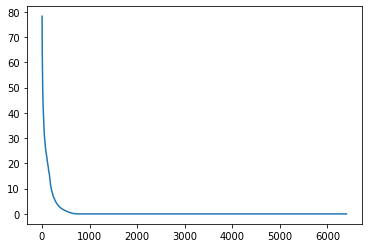

In [15]:
plt.plot(x,Eigen_values)
plt.show()

In [42]:
Eigen_values[-1]

-7.115551652388157e-07

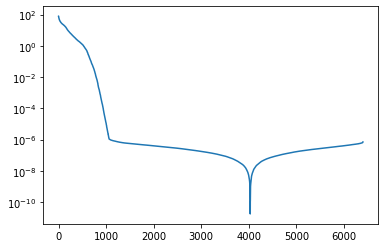

In [16]:
plt.plot(x,np.abs(Eigen_values))
plt.yscale("log")
plt.show()

- Now let us take a look at the eigen vectors.
- The eigen vectors of large eigen values have larger strctures,
- while the eigen vectors of tiny eigen values have smaller strctures

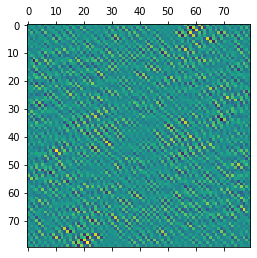

In [22]:
plt.matshow(util.array2image(Eigen_vectors[6000]))

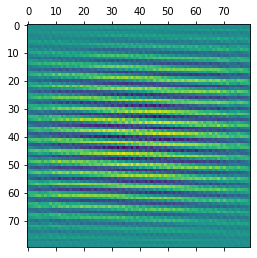

In [45]:
plt.matshow(util.array2image(Eigen_vectors[-10]))

## Now we have generated the covariance matrix
- M is the covariance matrix
- Eigen_values stores the eigen value (sorted in a descending sequence)
- Eigen_vectors stores the corresponding eigen vectors.

## Save them into file

In [46]:
FileM=open('E:\\lenstronomy\CovarianceMReal80.npy',"wb")

np.save(FileM,M)

FileM.close()

In [47]:
FileEigValue=open('E:\\lenstronomy\CovarianceMReal80EigValue.npy',"wb")

np.save(FileEigValue,Eigen_values)

FileEigValue.close()

In [48]:
FileEigVec=open('E:\\lenstronomy\CovarianceMReal80EigVec.npy',"wb")

np.save(FileEigVec,Eigen_vectors)

FileEigVec.close()

- If you just want to save the largest 2000 modes, you can run the following.

In [39]:
eig_value_2000_largest=Eigen_values[:2000]

In [40]:
eig_vec_2000_largest=Eigen_vectors[:2000]

In [29]:
FileEigValue=open('E:\\lenstronomy\CovarianceMReal100EigValue_2000largest.npy',"wb")

np.save(FileEigValue,eig_value_2000_largest)

FileEigValue.close()

In [30]:
FileEigVec=open('E:\\lenstronomy\CovarianceMReal100EigVec_2000largest.npy',"wb")

np.save(FileEigVec,eig_vec_2000_largest)

FileEigVec.close()

- check their dimensions

In [44]:
np.shape(eig_vec_2000_largest)

(2000, 6400)

In [43]:
eig_vec_2000_largest

array([[ 0.00362686,  0.00386892,  0.004081  , ...,  0.004081  ,
         0.00386892,  0.00362686],
       [-0.0024821 , -0.00256687, -0.00265033, ...,  0.00265033,
         0.00256687,  0.0024821 ],
       [ 0.00697629,  0.00768429,  0.008289  , ..., -0.008289  ,
        -0.00768429, -0.00697629],
       ...,
       [ 0.00348387, -0.00198736, -0.0014506 , ...,  0.0014506 ,
         0.00198736, -0.00348387],
       [ 0.00156771, -0.00405677,  0.00517079, ...,  0.00517079,
        -0.00405676,  0.00156771],
       [-0.00140975,  0.00259943, -0.00243729, ..., -0.00243729,
         0.00259943, -0.00140975]])

In [38]:
Eigen_vectors[0]

array([0.00362686, 0.00386892, 0.004081  , ..., 0.004081  , 0.00386892,
       0.00362686])